In [ ]:
import os
import cv2
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Pre Processing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path to dataset in Google Drive
base_dir = "/content/drive/MyDrive/Micro_Organism"  # Update with your actual path

# Output path for processed images
output_dir = "/content/drive/MyDrive/Processed_Micro_Organism"

# Output path for augmented images
augment_dir = "/content/drive/MyDrive/Augmented_Micro_Organism"

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(augment_dir, exist_ok=True)

In [ ]:
# Define standard image size
IMG_SIZE = (224, 224)

In [ ]:
def preprocess_image(img_path):
    """applies Gaussian noise."""
    img = cv2.imread(img_path)  # Read image
    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = img / 255.0  # Normalize to [0,1]

    # Apply Gaussian noise
    noise = np.random.normal(0, 0.05, img.shape)  # Mean=0, Std=0.05
    img_noisy = np.clip(img + noise, 0, 1)  # Clip to [0,1]

    return (img * 255).astype(np.uint8), (img_noisy * 255).astype(np.uint8)

In [ ]:
def process_and_save_images():
    for category in tqdm(os.listdir(base_dir)):  # Loop through each class
        class_path = os.path.join(base_dir, category)
        save_class_path = os.path.join(output_dir, category)

        os.makedirs(save_class_path, exist_ok=True)  # Create folder

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img, img_noisy = preprocess_image(img_path)

                cv2.imwrite(os.path.join(save_class_path, "noisy_" + img_name), img_noisy)  # Save noisy image
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [ ]:
process_and_save_images()
print("Processing complete! Images saved in:", output_dir)

100%|██████████| 8/8 [02:17<00:00, 17.19s/it]

Processing complete! Images saved in: /content/drive/MyDrive/Processed_Micro_Organism


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

def augment_images():
    for category in tqdm(os.listdir(output_dir)):  # Loop through each class
        class_path = os.path.join(output_dir, category)
        save_class_path = os.path.join(augment_dir, category)

        os.makedirs(save_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)  # Read image
            img = cv2.resize(img, IMG_SIZE)  # Resize

            img = np.expand_dims(img, axis=0)  # Add batch dimension
            aug_iter = datagen.flow(img, batch_size=1)

            for i in range(3):  # Generate 3 augmented images per original image
                aug_img = next(aug_iter)[0].astype(np.uint8)
                cv2.imwrite(os.path.join(save_class_path, f"aug_{i}_" + img_name), aug_img)

In [ ]:
augment_images()
print("Augmentation complete! Augmented images saved in:", augment_dir)

100%|██████████| 8/8 [00:36<00:00,  4.55s/it]

Augmentation complete! Augmented images saved in: /content/drive/MyDrive/Augmented_Micro_Organism


In [ ]:
import random


# Define minimum and maximum image counts
min_class_count = 40  # Rotifer
max_class_count = 119  # Nematode

balanced_dir = "/content/drive/MyDrive/Balanced_Micro_Organism"
os.makedirs(balanced_dir, exist_ok=True)

def balance_classes():
    for category in tqdm(os.listdir(augment_dir)):  # Iterate over each class
        class_path = os.path.join(augment_dir, category)
        save_class_path = os.path.join(balanced_dir, category)

        os.makedirs(save_class_path, exist_ok=True)

        images = os.listdir(class_path)
        current_count = len(images)

        if current_count < max_class_count:
            extra_images = random.choices(images, k=max_class_count - current_count)
            images.extend(extra_images)  # Duplicate images

        for i, img_name in enumerate(images[:max_class_count]):  # Save balanced set
            src_path = os.path.join(class_path, img_name)
            dest_path = os.path.join(save_class_path, f"balanced_{i}_" + img_name)
            shutil.copy(src_path, dest_path)

In [ ]:
balance_classes()
print("Class balancing complete! Balanced dataset saved in:", balanced_dir)

100%|██████████| 8/8 [00:08<00:00,  1.07s/it]

Class balancing complete! Balanced dataset saved in: /content/drive/MyDrive/Balanced_Micro_Organism


# Yolo

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6z0wjSGJiiONq7f6SYCy")
project = rf.workspace("microbe-classification").project("final-microbe-detection-annotated-dataset")
version = project.version(1)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Final-Microbe-Detection-Annotated-Dataset-1 in yolov11:: 100%|██████████| 1910/1910 [00:00<00:00, 6956.90it/s]


In [ ]:
!yolo detect train data=/content/Final-Microbe-Detection-Annotated-Dataset-1/data.yaml model=yolo11s.pt epochs=100 imgsz=640

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Final-Microbe-Detection-Annotated-Dataset-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

In [ ]:
import torch
import cv2
import os
import numpy as np
from ultralytics import YOLO

# Path to YOLO model
yolo_model_path = "/content/drive/MyDrive/runs/runs/detect/train/weights/best.pt"
yolo_model = YOLO(yolo_model_path)

# Path to images
train_folder = "/content/drive/MyDrive/Final Microbe Detection Annotated Dataset.v1i.yolov11/train/images"
test_folder = "/content/drive/MyDrive/Final Microbe Detection Annotated Dataset.v1i.yolov11/test/images"
output_folder = "/content/drive/MyDrive/Cropped_Microbes"

# Class Names (Adjust based on your model)
class_names = ["Amoeba", "Rod bacteria", "Spherical bacteria", "Spiral bacteria", "Yeast", "Microalgae", "Rotifer", "Nematode"]

# Function to crop and save images
def process_images(input_folder, data_type):
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)

        # YOLO Inference
        results = yolo_model(img_path)

        # Extract Bounding Boxes and Classes
        for result in results:
            for i, (box, cls) in enumerate(zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy())):
                x1, y1, x2, y2 = map(int, box)
                class_label = class_names[int(cls)]

                # Crop the Microbe
                cropped_img = image[y1:y2, x1:x2]

                # Save to Class-wise Folder (Train/Test)
                save_path = os.path.join(output_folder, data_type, class_label)
                os.makedirs(save_path, exist_ok=True)
                crop_path = os.path.join(save_path, f"{img_name}_crop_{i}.jpg")
                cv2.imwrite(crop_path, cropped_img)

# Process Train and Test Images
process_images(train_folder, "train")
process_images(test_folder, "test")

print("Cropped microbes saved successfully in class-wise folders in Google Drive!")



image 1/1 /content/drive/MyDrive/Final Microbe Detection Annotated Dataset.v1i.yolov11/train/images/balanced_101_aug_2_noisy_EMDS7-G062-028-0400_png.rf.4a40b96a45967c331aa374bf7c895166.jpg: 640x640 1 Rotifer, 44.8ms
Speed: 11.7ms preprocess, 44.8ms inference, 681.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Final Microbe Detection Annotated Dataset.v1i.yolov11/train/images/balanced_0_aug_0_noisy_Image_106_jpg.rf.0777c518e55abf8a4e8cfd009fb613b7.jpg: 640x640 1 Sphericalbacteria, 94.3ms
Speed: 12.6ms preprocess, 94.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Final Microbe Detection Annotated Dataset.v1i.yolov11/train/images/balanced_0_aug_0_noisy_Chaestoceros-25-_jpg.rf.6972b0a49d994160f60649c9b6056fa5.jpg: 640x640 3 Microalgaes, 55.7ms
Speed: 3.6ms preprocess, 55.7ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Final Microbe Detection

# VGG16


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Google Drive Paths
train_val_path = "/content/drive/MyDrive/Cropped_Microbes/train"  # Train + Validation
test_path = "/content/drive/MyDrive/Cropped_Microbes/test"  #  New Test Folder

# Image Size & Batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

#  Train-Validation Data Generator (80-20 Split)
train_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% Train, 20% Validation
)

#  Test Data Generator (Only Rescaling, No Augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)

#  Load Train Data (80%)
train_data = train_val_datagen.flow_from_directory(
    train_val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

#  Load Validation Data (20%)
val_data = train_val_datagen.flow_from_directory(
    train_val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

#  Load Test Data (From Separate Test Folder)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data
)

#  Print Class Indices
print("Class Mapping: ", train_data.class_indices)


Found 748 images belonging to 8 classes.
Found 182 images belonging to 8 classes.
Found 133 images belonging to 8 classes.
Class Mapping:  {'Amoeba': 0, 'Microalgae': 1, 'Nematode': 2, 'Rod bacteria': 3, 'Rotifer': 4, 'Spherical bacteria': 5, 'Spiral bacteria': 6, 'Yeast': 7}


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load pre-trained VGG16 (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 Layers (do NOT train them)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling instead of Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=output_layer)  # Corrected outputs

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,879,944 (56.76 MB)

 Trainable params: 165,256 (645.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.2088 - loss: 2.0519 - val_accuracy: 0.4121 - val_loss: 1.5574
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.4333 - loss: 1.5688 - val_accuracy: 0.5000 - val_loss: 1.3151
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 343ms/step - accuracy: 0.5238 - loss: 1.3332 - val_accuracy: 0.5769 - val_loss: 1.1629
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - accuracy: 0.6118 - loss: 1.0918 - val_accuracy: 0.6648 - val_loss: 1.0595
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.6219 - loss: 1.0826 - val_accuracy: 0.6538 - val_loss: 1.0769
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step - accuracy: 0.6431 - loss: 0.9836 - val_accuracy: 0.6154 - val_loss: 0.9848
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.6971 - loss: 0.8846 - val_accuracy: 0.6319 - val_loss: 1.0216
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step - accuracy: 0.6844 - loss: 0.8953 - val_accura

In [ ]:
# Path to save the trained model
model_save_path = "/content/drive/MyDrive/VGG16_Microbe_Classifier.h5"

# Save model
model.save(model_save_path)
print(f" Model saved at {model_save_path}")


 Model saved at /content/drive/MyDrive/VGG16_Microbe_Classifier.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/drive/MyDrive/VGG16_Microbe_Classifier.h5")


In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_data)

# Print the evaluation results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4%}")  # Converts to percentage


9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6973 - loss: 0.8203
Test Loss: 0.6719
Test Accuracy: 76.6917%


In [ ]:
import numpy as np

# Get predictions
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get true labels
true_classes = test_data.classes

# Print results
print(f"Predicted Classes: {predicted_classes}")
print(f"True Classes: {true_classes}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
Predicted Classes: [0 0 2 0 0 5 7 0 0 0 2 0 0 0 0 0 3 6 6 1 1 1 1 3 1 3 1 1 4 6 1 6 6 0 6 6 2
 2 2 2 2 2 2 0 3 3 3 0 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3
 3 3 3 2 3 3 3 4 4 4 4 2 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 6 2
 6 6 6 6 4 4 4 6 6 7 7 7 7 7 7 7 0 1 7 7 7 7]
True Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7]


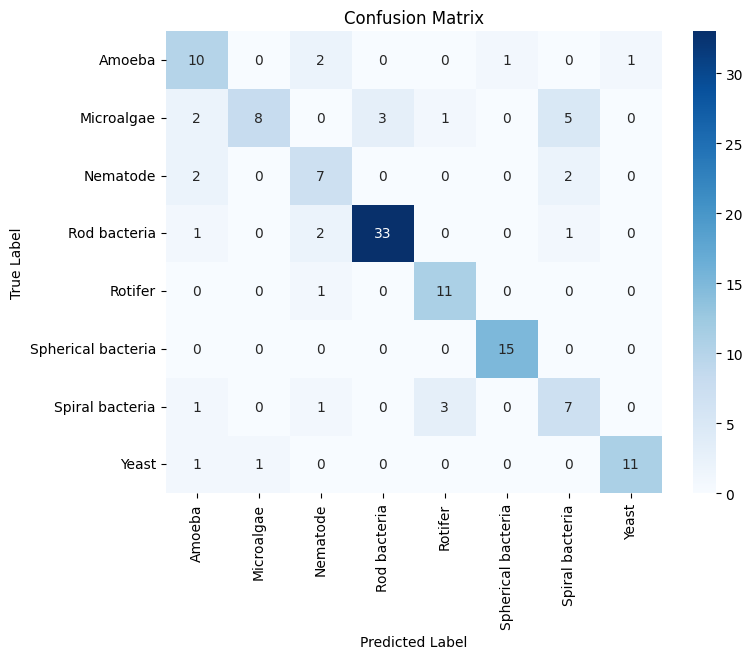

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())

# Print report
print(report)


                    precision    recall  f1-score   support

            Amoeba       0.59      0.71      0.65        14
        Microalgae       0.89      0.42      0.57        19
          Nematode       0.54      0.64      0.58        11
      Rod bacteria       0.92      0.89      0.90        37
           Rotifer       0.73      0.92      0.81        12
Spherical bacteria       0.94      1.00      0.97        15
   Spiral bacteria       0.47      0.58      0.52        12
             Yeast       0.92      0.85      0.88        13

          accuracy                           0.77       133
         macro avg       0.75      0.75      0.74       133
      weighted avg       0.79      0.77      0.76       133



# AlexNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set paths
dataset_path = "/content/drive/MyDrive/Cropped_Microbes/train"  # Train + Validation
test_path = "/content/drive/MyDrive/Cropped_Microbes/test"

IMG_SIZE = (227, 227)  # AlexNet uses 227x227 images
BATCH_SIZE = 16


In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 train-validation split
)
test_datagen = ImageDataGenerator(rescale=1.0/255)
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print class labels
print("Class Mapping: ", train_data.class_indices)


Found 748 images belonging to 8 classes.
Found 182 images belonging to 8 classes.
Found 133 images belonging to 8 classes.
Class Mapping:  {'Amoeba': 0, 'Microalgae': 1, 'Nematode': 2, 'Rod bacteria': 3, 'Rotifer': 4, 'Spherical bacteria': 5, 'Spiral bacteria': 6, 'Yeast': 7}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define AlexNet model
def create_alexnet(input_shape=(227, 227, 3), num_classes=8):
    model = models.Sequential()

    # Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=4, padding='valid', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    # Layer 2
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    # Layer 3
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create AlexNet model
model = create_alexnet()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │          32,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,315,528 (222.46 MB)

 Trainable params: 58,314,824 (222.45 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - accuracy: 0.2172 - loss: 6.4415 - val_accuracy: 0.2692 - val_loss: 2.0043
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - accuracy: 0.2363 - loss: 2.0397 - val_accuracy: 0.2692 - val_loss: 2.0061
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - accuracy: 0.2890 - loss: 1.9824 - val_accuracy: 0.2692 - val_loss: 2.0072
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.2789 - loss: 2.0064 - val_accuracy: 0.2692 - val_loss: 2.0020
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.2538 - loss: 2.0216 - val_accuracy: 0.2692 - val_loss: 2.0014
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.2610 - loss: 2.0108 - val_accuracy: 0.2692 - val_loss: 2.0068
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - accuracy: 0.2855 - loss: 2.0011 - val_accuracy: 0.2692 - val_loss: 2.0059
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.2518 - loss: 2.0224 - val_accu

In [ ]:
# Path to save the trained model
model_save_path = "/content/drive/MyDrive/AlexNet_Microbe_Classifier.h5"

# Save model
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at /content/drive/MyDrive/AlexNet_Microbe_Classifier.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/drive/MyDrive/AlexNet_Microbe_Classifier.h5")


In [ ]:
# Evaluate on Test Data
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.2407 - loss: 1.9950
Test Loss: 1.9927177429199219
Test Accuracy: 0.27819550037384033
